In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import csv
import os
from nltk.tokenize import word_tokenize
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

In [2]:
training_data_df = pd.read_csv('/kaggle/input/sarcasm-glove/Sarcasm_training.csv')
training_data_df = training_data_df[['TEXT ', 'IS_SARCASTIC']]
training_data_df['IS_SARCASTIC'] = pd.to_numeric(training_data_df['IS_SARCASTIC'], errors='coerce')
train_data_df_cleaned = training_data_df[training_data_df['IS_SARCASTIC'].isin([0, 1])]
invalid_rows_after_cleanup = train_data_df_cleaned[~train_data_df_cleaned['IS_SARCASTIC'].isin([0, 1])]
invalid_rows_count_after_cleanup = len(invalid_rows_after_cleanup)
training_data_df = train_data_df_cleaned
training_data_df.rename(columns={"TEXT ": "TEXT"}, inplace=True)
training_data_df

,TEXT,IS_SARCASTIC
0,it's another ho-ho-horowitz christmas!,0.0
1,quiz: where should you live abroad?,0.0
2,praise the lord or praise the person?,0.0
3,microwave-resistant potato alarms scientists,1.0
4,rude guy unfortunately says something funny,1.0
...,...,...
25705,u.s. changes motto to 'america... we're gonna ...,1.0
25706,why this healing expert doesn't believe in 'cl...,0.0
25707,man just going to assume apartment has functio...,1.0
25708,5 signs that you should end your relationship,0.0


In [3]:
train_val_split_factor = 0.8

num_training_samples = int(len(training_data_df) * train_val_split_factor)

shuffled_indices = np.random.RandomState(seed=150).permutation(len(training_data_df))

train_indices = shuffled_indices[:num_training_samples]
val_indices = shuffled_indices[num_training_samples:]


train_data_df = training_data_df.iloc[train_indices].reset_index(drop=True)
val_df = training_data_df.iloc[val_indices].reset_index(drop=True)
len(train_data_df), len(val_df)

(20545, 5137)

In [4]:

def load_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


class SarcasmDataset(Dataset):
    def __init__(self, dataframe, word_vectors):
        self.data = dataframe
        self.word_vectors = word_vectors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['TEXT']
        label = self.data.iloc[idx]['IS_SARCASTIC']
        vector = self.sentence_to_vector(text)
        return vector, label

    def sentence_to_vector(self, sentence):
        tokens = word_tokenize(sentence.lower())
        vector = []
        for token in tokens:
            if token in self.word_vectors:
                vector.append(self.word_vectors[token])
        if not vector:
            vector.append(np.zeros(50))  
        return np.mean(vector, axis=0)

local_embeddings_path = '/kaggle/input/sarcasm-glove/glove.6B.50d.txt'
word_vectors = load_embeddings(local_embeddings_path)

train_dataset = SarcasmDataset(train_data_df, word_vectors)
val_dataset = SarcasmDataset(val_df, word_vectors)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.rnn1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)      
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Adding dim for batch_first LSTM
        output, _ = self.rnn1(x)
        output = self.fc1(output)
        output = F.relu(output)   
        output = self.dropout1(output)        
        output = self.fc2(output[:, -1, :])  #last time step
        return output

In [6]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pretrained_embeddings=None):
        super(RNNModel, self).__init__()
        
        # If pre-trained word embeddings are provided, load them
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
            # If you want to freeze the embeddings, set the following flag
            # self.embedding.weight.requires_grad = False

        self.rnn1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Here, x is expected to be a batch of word indices
        embedded = self.embedding(x)
        output, _ = self.rnn1(embedded)
        output = self.fc1(output)
        output = F.relu(output)
        output = self.dropout1(output)
        output = self.fc2(output[:, -1, :])  # Get the output of the last time step
        return output


In [7]:
embedding_dim = 50
hidden_dim = 32

model = LSTMModel(embedding_dim, hidden_dim).to(device)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [8]:
def train_model(model,device,train_dataloader):
    model.train()
    total_predictions = 0
    correct_predictions = 0
    train_loss = 0
    for batch_idx, (inputs,labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs.squeeze(), labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        output_probabilities = F.sigmoid(outputs)
        preds = (output_probabilities >= 0.5).float()
        correct_predictions += torch.sum(preds.squeeze(1)  == labels).item()
        total_predictions += labels.size(0)

    avg_train_loss = train_loss / len(train_dataloader)  
    train_accuracy = 100 * correct_predictions / total_predictions
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%')
    return avg_train_loss,train_accuracy

In [9]:
def validation_check(model,device,validation_dataloader):
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs,labels) in enumerate(validation_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()
            output_probabilities = F.sigmoid(outputs)
            preds = (output_probabilities >= 0.5).float()
            correct_val += torch.sum(preds.squeeze(1)  == labels).item()
            total_val += labels.size(0)
    avg_val_loss = val_loss / len(validation_dataloader)
    val_accuracy = 100 * correct_val / total_val
    # print(f'Validation Accuracy: {val_accuracy:.2f}%')
    return avg_val_loss,val_accuracy

In [10]:
model_save_path = 'model.pth' 
model_state_dict_path = 'model_state_dict.pth'
epochs = 50
training_losses = []
training_accs = []
val_losses = []
val_accs = []
start_time = time.time()
for epoch in range(epochs):
    loss, accuracy = train_model(model,device,train_loader)
    training_losses.append(loss)
    training_accs.append(accuracy)
    val_loss, val_acc = validation_check(model, device, val_loader)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    e_time = (time.time() - start_time)/60
    print(f"epoch: {epoch+1}, train loss: {loss:.4f}, val. loss: {val_loss:.4f}, train acc: {accuracy:.4f}, val acc: {val_acc:.4f}, time: {e_time:.2f} mins")
    torch.save(model, model_save_path)
    torch.save(model.state_dict(), model_state_dict_path)
    epoch_nums = list(range(1, epoch+2))
    csv_file_path = "losses.csv"
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy"])   
        for epoch, train_loss, validation_loss, tacc, vacc in zip(epoch_nums, training_losses, val_losses, training_accs, val_accs):
            writer.writerow([epoch, train_loss, validation_loss, tacc, vacc])

epoch: 1, train loss: 0.6055, val. loss: 0.5705, train acc: 67.2264, val acc: 70.8585, time: 0.20 mins
epoch: 2, train loss: 0.5612, val. loss: 0.5523, train acc: 71.7290, val acc: 72.7467, time: 0.39 mins
epoch: 3, train loss: 0.5427, val. loss: 0.5372, train acc: 72.8826, val acc: 73.3307, time: 0.59 mins
epoch: 4, train loss: 0.5288, val. loss: 0.5230, train acc: 73.7636, val acc: 74.5377, time: 0.78 mins
epoch: 5, train loss: 0.5161, val. loss: 0.5188, train acc: 74.8880, val acc: 74.6739, time: 0.98 mins
epoch: 6, train loss: 0.5038, val. loss: 0.5084, train acc: 75.6620, val acc: 75.7251, time: 1.17 mins
epoch: 7, train loss: 0.4963, val. loss: 0.5051, train acc: 76.2802, val acc: 75.9587, time: 1.37 mins
epoch: 8, train loss: 0.4908, val. loss: 0.5001, train acc: 76.6209, val acc: 75.7057, time: 1.56 mins
epoch: 9, train loss: 0.4848, val. loss: 0.4953, train acc: 77.0006, val acc: 75.9393, time: 1.75 mins
epoch: 10, train loss: 0.4798, val. loss: 0.4951, train acc: 77.1320, val

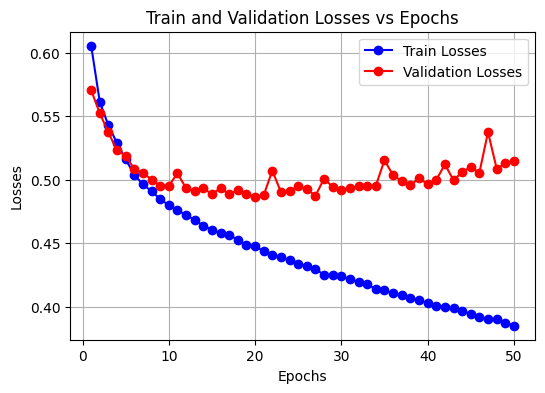

In [11]:
epoch_nums = list(range(1, epochs+1))
plt.figure(figsize=(6, 4))
plt.plot(epoch_nums, training_losses, '-o', color='b', label='Train Losses')
plt.plot(epoch_nums, val_losses, '-o', color='r', label='Validation Losses')

plt.title('Train and Validation Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid(True)
plt.legend()
plt.savefig('train_and_validation_losses.png')
plt.show()

In [12]:
test_data_df = pd.read_csv('/kaggle/input/sarcasm-detection/SarcasmHeadlinesDataset_test.csv')
# test_data_df
# test_data_df.columns
test_data_df = test_data_df[['ID','TEXT']]


def sentence_to_vector(sentence, word_vectors):
    tokens = word_tokenize(sentence.lower())
    vector = []
    for token in tokens:
        if token in word_vectors:
            vector.append(word_vectors[token])
    if not vector:
        vector.append(np.zeros(50))
    return np.mean(np.array(vector), axis=0)

def predict_sarcasm(sentence, word_vectors, model, device):
    model.eval() 
    with torch.no_grad(): 
        sentence_vector = sentence_to_vector(sentence, word_vectors)
        sentence_vector = torch.tensor(sentence_vector).float().to(device)
        sentence_vector = sentence_vector.unsqueeze(0)  
        output = model(sentence_vector)
        output_probabilities = F.sigmoid(output)
        preds = (output_probabilities >= 0.5).float()
#         prediction = torch.sigmoid(output)
        return preds
    
    
all_preds = []
for index, row in test_data_df.iterrows():
    ID = row['ID']
    sentence = row['TEXT']
    pred_tensor = predict_sarcasm(sentence,word_vectors, model, device) 
    pred = int(pred_tensor.cpu().numpy().flatten()[0])
    all_preds.append((ID, pred))

results_df = pd.DataFrame(all_preds, columns=['ID', 'IS_SARCASTIC'])
results_df.to_csv('predictions.csv', index=False) 